<a href="https://colab.research.google.com/github/dajiro-repo/blog/blob/master/blog_timm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.optim as optim

In [2]:
!pip install timm
import timm

     |████████████████████████████████| 215kB 3.4MB/s 


In [20]:
###############
# 入力パラメータ
###############
#モデル名
model_name = 'efficientnet_b0'
#画像のパス
image_path = './imagenetv2-matched-frequency-format-val/'
#バッチサイズ
batch_size = 32
#エポック数
epochs = 5
#GPUID
ngpu = 1
#ラベル数
n_class = 1000
#画像サイズ
image_size = 224
#ワーカー数
workers = 1
#訓練用データ比率
train_ratio = 0.7
#検証用データ比率
val_ratio = 0.2
#学習率
lr = 0.001
#Adamのbeta1
beta1 = 0.9
#チャネル数
nc = 3
#中間層チャネル数のユニット
ndf = 16
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [12]:
if not os.path.exists('./imagenetv2-matched-frequency-format-val/'):
    !curl -s https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-matched-frequency.tar.gz | tar x
# dataset = Dataset('./imagenetv2-matched-frequency-format-val/')
# for i in range(len(dataset)): # warmup
#     dummy = dataset[i]

In [21]:
def get_data_loaders(batch_size, conf, train_ratio, val_ratio):
    dataset = dset.ImageFolder(root=image_path,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(conf["mean"], conf["std"]),
                               ]))

    num_data = len(dataset)
    num_list = [int(train_ratio * num_data),
                int(val_ratio * num_data),
                num_data -
                int(train_ratio * num_data) -
                int(val_ratio * num_data)]
    collate_fn = None
    train_data, val_data, test_data = utils.data.random_split(dataset,
                                                              [num_list[0],
                                                               num_list[1],
                                                               num_list[2]])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             shuffle=True, num_workers=workers,
                                             collate_fn = collate_fn)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                             shuffle=True, num_workers=workers,
                                             collate_fn = collate_fn)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                             shuffle=True, num_workers=workers,
                                             collate_fn = collate_fn)
    
    return train_loader, val_loader, test_loader

In [22]:
data_config = timm.data.resolve_data_config({}, model=model_name, verbose=True)

class EfficientNet_b0(nn.Module):
    def __init__(self, n_out):
        super(EfficientNet_b0, self).__init__()
        self.effnet = timm.create_model(model_name, pretrained=True)
        self.effnet.classifier = nn.Linear(1280, n_out)

    def forward(self, x):
        return self.effnet(x)

In [23]:
#モデル
model = EfficientNet_b0(n_class)
params_to_update = []
update_param_names = ["effnet.classifier.weight", "effnet.classifier.bias"]
for name, param in model.named_parameters():
    if name in update_param_names:
      param.requires_grad = True
      params_to_update.append(param)
    else:
      param.requires_grad = False

In [24]:
# 損失関数（closs entropy）
criterion = nn.CrossEntropyLoss()
#Optimizer(Adamを使用)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

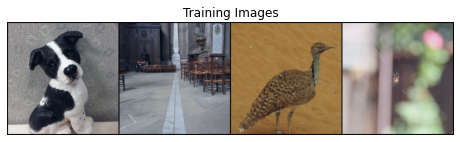

In [25]:
train_loader, val_loader, test_loader = get_data_loaders(batch_size,
                                                         data_config,
                                                         train_ratio,
                                                         val_ratio)
dataloaders_dict = {"train":train_loader, "val":val_loader}

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:4], padding=2, normalize=True).cpu(),(1,2,0)))

In [26]:
accuracy, accuracy_val = [], []
model.to(device)
for epoch in range(epochs):

    for phase in ["train", "val"]:
        if phase == "train":
          model.train()
        else:
          model.eval()

        loss_epoch = 0.0
        acc_epoch = 0.0

        if (epoch == 0) and (phase == "train"):
            continue

        for inputs, labels in dataloaders_dict[phase]:
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == "train"):
                labels = labels.to(device)
                inputs = inputs.to(device)
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                
                loss_epoch += loss.item() * inputs.size(0)
                acc_epoch += torch.sum(preds == labels.data)
        
        loss_epoch = loss_epoch / len(dataloaders_dict[phase].dataset)
        acc_epoch = acc_epoch.double() / len(dataloaders_dict[phase].dataset)
        print(f"phase: {phase}",
              f"LR: {scheduler.get_last_lr()[0]} "
              f"epoch: {epoch}",
              f"loss: {loss_epoch:.4f}",
              f"accuracy: {acc_epoch:.4f}")
             # f"accuracy: {acc_epoch}:.4f}")
        if phase == "train":
            scheduler.step()

print('Finished Training')

phase: val LR: 0.001epoch: 0 loss: 6.9350 accuracy: 0.0010
phase: train LR: 0.001epoch: 1 loss: 6.0797 accuracy: 0.1490
phase: val LR: 0.001epoch: 1 loss: 4.4728 accuracy: 0.3150
phase: train LR: 0.001epoch: 2 loss: 2.1574 accuracy: 0.7431
phase: val LR: 0.001epoch: 2 loss: 3.1850 accuracy: 0.4150
phase: train LR: 0.001epoch: 3 loss: 0.8378 accuracy: 0.9224
phase: val LR: 0.001epoch: 3 loss: 2.8108 accuracy: 0.4515
phase: train LR: 0.001epoch: 4 loss: 0.3998 accuracy: 0.9771
phase: val LR: 0.001epoch: 4 loss: 2.6884 accuracy: 0.4525
Finished Training
